Import Libraries and Dataset

In [43]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import unique, where
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import warnings
import sys

# Ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Loading the dataset
data = pd.read_csv("driver-data.csv", sep=",")
print(data.head())  # Display the first few rows of the dataset


           id  mean_dist_day  mean_over_speed_perc
0  3423311935          71.24                    28
1  3423313212          52.53                    25
2  3423313724          64.54                    27
3  3423311373          55.69                    22
4  3423310999          54.58                    25


In [44]:
# Data overview
data.shape  # Get the number of rows and columns
data.info()  # Check for data types and missing values
data.describe()  # Get summary statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4000 non-null   int64  
 1   mean_dist_day         4000 non-null   float64
 2   mean_over_speed_perc  4000 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 93.9 KB


,id,mean_dist_day,mean_over_speed_perc
count,4.000000e+03,4000.000000,4000.000000
mean,3.423312e+09,76.041522,10.721000
std,1.154845e+03,53.469563,13.708543
min,3.423310e+09,15.520000,0.000000
25%,3.423311e+09,45.247500,4.000000
50%,3.423312e+09,53.330000,6.000000
75%,3.423313e+09,65.632500,9.000000
max,3.423314e+09,244.790000,100.000000


In [45]:
# Strip any leading or trailing whitespace from column names
data.columns = data.columns.str.strip()
print(data.columns)


Index(['id', 'mean_dist_day', 'mean_over_speed_perc'], dtype='object')


In [46]:
# Ensure the data is numeric and clean
data = data.select_dtypes(include=[np.number])  # Keep only numerical columns
data.fillna(data.mean(), inplace=True)  # Fill missing values with column means



Scatter Plot: Mean Distance Day vs Mean Speed

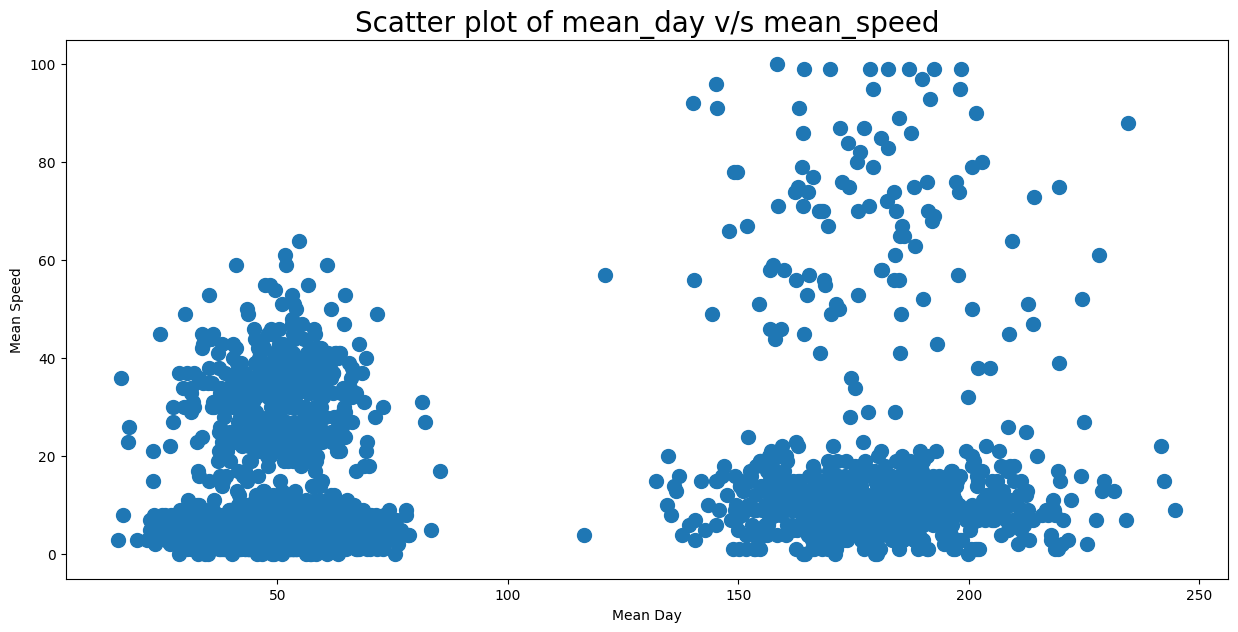

In [47]:
plt.figure(1 , figsize = (15 , 7))
plt.title('Scatter plot of mean_day v/s mean_speed', fontsize = 20)
plt.xlabel('Mean Day')
plt.ylabel('Mean Speed')
plt.scatter( x = 'mean_dist_day', y = 'mean_over_speed_perc', data = data, s = 100)
plt.show()

Elbow Method to Find Optimal K for KMeans

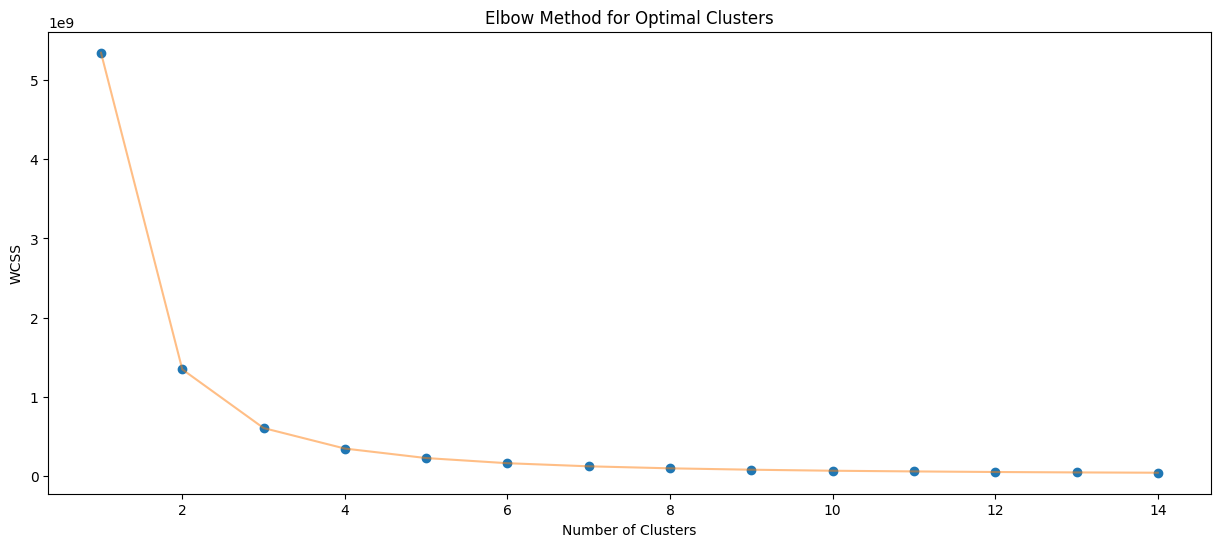

In [48]:
# Compute inertia for a range of cluster counts
inertia = []
for n_clusters in range(1, 15):  # Clusters from 1 to 14
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

# Plot the inertia (Elbow method)
plt.figure(1, figsize=(15, 6))
plt.plot(np.arange(1, len(inertia) + 1), inertia, 'o')  # Match x-axis to inertia length
plt.plot(np.arange(1, len(inertia) + 1), inertia, '-', alpha=0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

KMeans Clustering

In [49]:

kmeans = KMeans(n_clusters=4)
kmeans.fit(data)


KMeans(n_clusters=4)

In [50]:
# Add cluster labels to the data
data['kmeans_cluster'] = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_

KMeans clustering visualization (k=4)

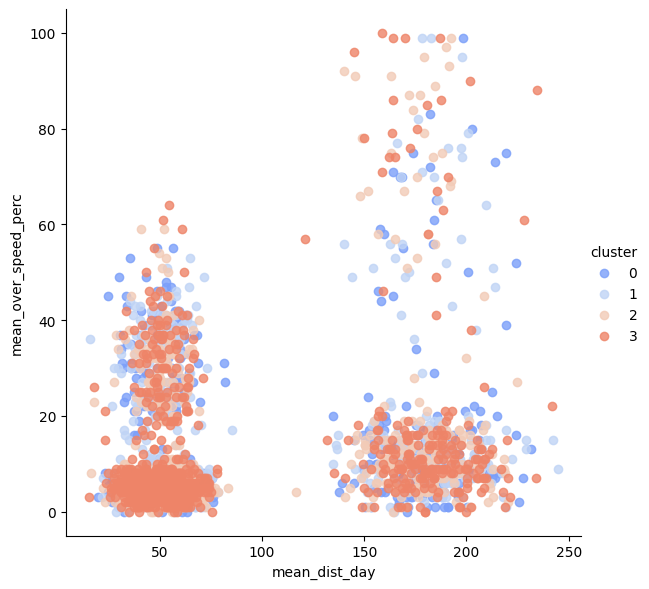

In [51]:
data["cluster"] = kmeans.labels_

# Create a scatter plot with Seaborn lmplot
sns.lmplot(
    x='mean_dist_day',  
    y='mean_over_speed_perc',  
    data=data,  
    hue='cluster',  
    palette='coolwarm',  
    height=6,  
    aspect=1,  
    fit_reg=False  
)


KMeans clustering visualization (k=4) with centroids

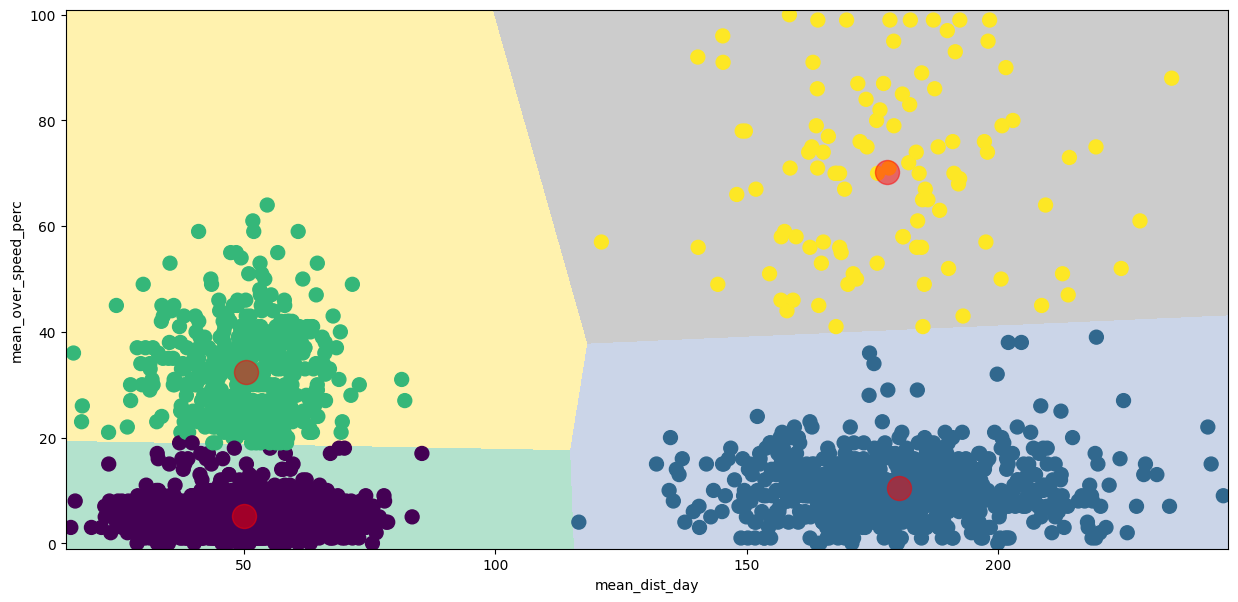

In [52]:

# Extract relevant features for clustering
X = data[['mean_dist_day', 'mean_over_speed_perc']].values  # Use only the 2D features

algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'mean_dist_day', y = 'mean_over_speed_perc', data = data, c = labels1, s = 100)
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('mean_over_speed_perc') , plt.xlabel('mean_dist_day')
plt.show()

Comparing KMeans with DBSCAN

In [53]:
# KMeans Model (k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
data['kmeans_cluster'] = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_

# DBSCAN Model
dbscan_model = DBSCAN(eps=0.5, min_samples=5)  # Tune eps and min_samples as needed
dbscan_labels = dbscan_model.fit_predict(X)
data['dbscan_cluster'] = dbscan_labels
# Label noise points as a separate category for plotting
data['dbscan_label'] = data['dbscan_cluster'].apply(lambda x: 'Noise' if x == -1 else 'Cluster')

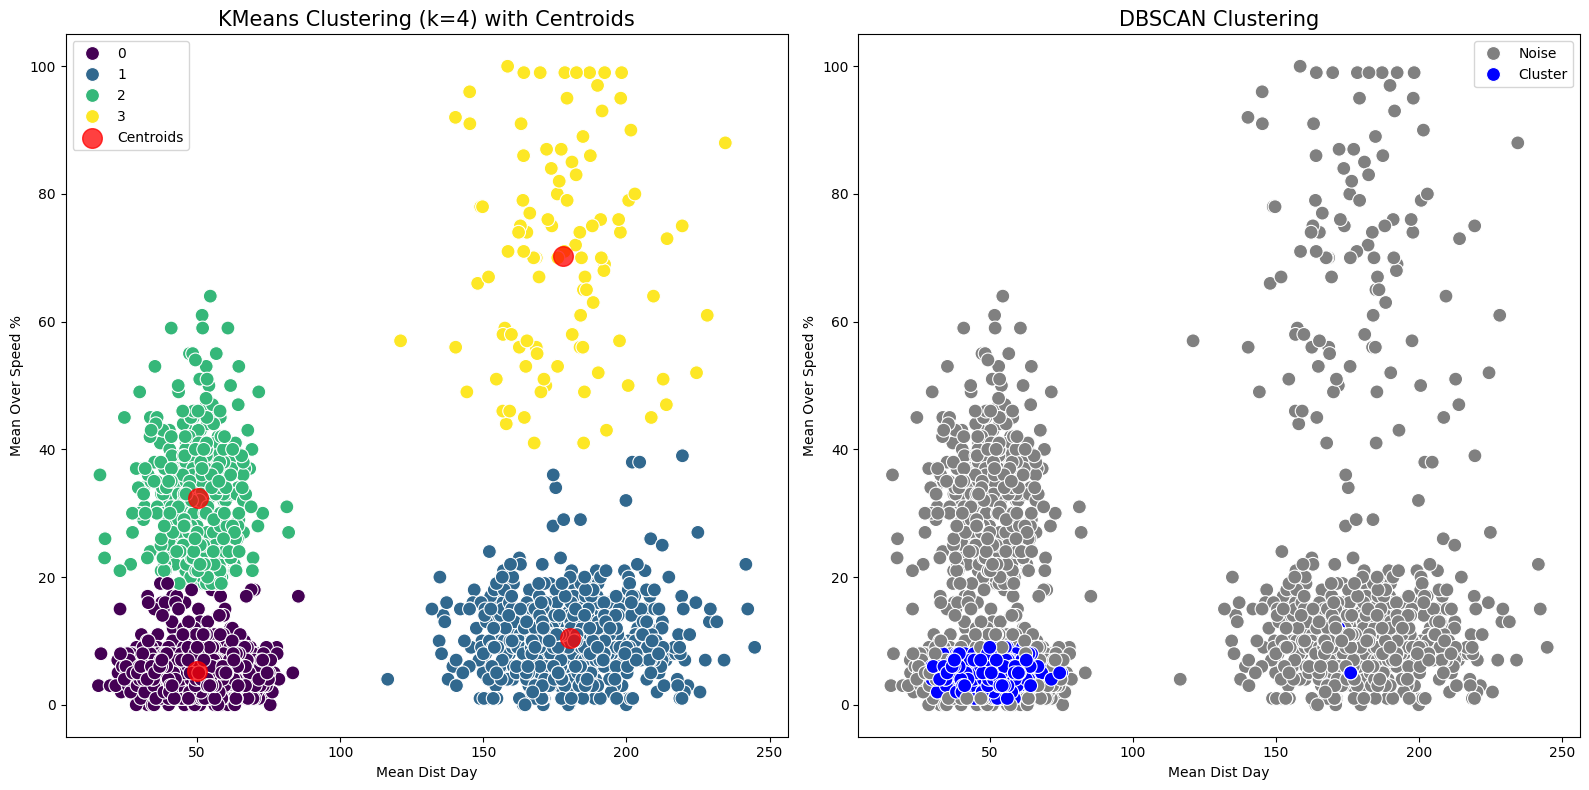

In [54]:

# Visualization: KMeans vs DBSCAN with centroid comparison
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# KMeans Clustering with Centroids (Hue for clusters)
sns.scatterplot(
    x=data['mean_dist_day'], 
    y=data['mean_over_speed_perc'], 
    hue=data['kmeans_cluster'], 
    palette='viridis', 
    s=100, 
    ax=axs[0], 
    legend='full'
)
axs[0].scatter(
    kmeans_centroids[:, 0], 
    kmeans_centroids[:, 1], 
    c='red', 
    s=200, 
    alpha=0.75, 
    label='Centroids'
)
axs[0].set_title("KMeans Clustering (k=4) with Centroids", fontsize=15)
axs[0].set_xlabel('Mean Dist Day')
axs[0].set_ylabel('Mean Over Speed %')
axs[0].legend()

# DBSCAN Clustering 
sns.scatterplot(
    x=data['mean_dist_day'], 
    y=data['mean_over_speed_perc'], 
    hue=data['dbscan_label'],  # Label Noise and Clusters separately
    data=data, 
    palette={'Noise': 'gray', 'Cluster': 'blue'},  # Noise is gray, all other points in blue
    s=100, 
    ax=axs[1], 
    legend='full'
)
axs[1].set_title("DBSCAN Clustering", fontsize=15)
axs[1].set_xlabel('Mean Dist Day')
axs[1].set_ylabel('Mean Over Speed %')
axs[1].legend()

plt.tight_layout()
plt.show()



Silhouette Score Calculation for Comparison

In [55]:


# Label noise as a separate category (use 'Noise' for noise points)
data['dbscan_label'] = data['dbscan_cluster'].apply(lambda x: 'Noise' if x == -1 else 'Cluster')

# Compute Silhouette Scores
# KMeans Silhouette Score
kmeans_silhouette = silhouette_score(X, data['kmeans_cluster'])

# DBSCAN Silhouette Score (excluding noise points)
dbscan_silhouette = silhouette_score(X[data['dbscan_cluster'] != -1], data['dbscan_cluster'][data['dbscan_cluster'] != -1])

# Print clustering results summary
print("Clustering Results:")
print(f"K-means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"DBSCAN Silhouette Score (excluding noise): {dbscan_silhouette:.4f}")

Clustering Results:
K-means Silhouette Score: 0.5911
DBSCAN Silhouette Score (excluding noise): -0.3420
